In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalMaxPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 128)    0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 128)    0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4778 - acc: 0.1876
Epoch 00001: val_loss improved from inf to 2.10802, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/001-2.1080.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 2.4778 - acc: 0.1876 - val_loss: 2.1080 - val_acc: 0.3452
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1103 - acc: 0.2949
Epoch 00002: val_loss improved from 2.10802 to 1.82852, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/002-1.8285.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 2.1103 - acc: 0.2949 - val_loss: 1.8285 - val_acc: 0.4263
Epoch 3/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 1.0533 - acc: 0.6561
Epoch 00021: val_loss improved from 0.82636 to 0.79841, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/021-0.7984.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.0533 - acc: 0.6560 - val_loss: 0.7984 - val_acc: 0.7508
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0389 - acc: 0.6632
Epoch 00022: val_loss improved from 0.79841 to 0.79246, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/022-0.7925.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.0389 - acc: 0.6632 - val_loss: 0.7925 - val_acc: 0.7496
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0193 - acc: 0.6693
Epoch 00023: val_loss improved from 0.79246 to 0.77464, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/023-0

Epoch 43/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8673 - acc: 0.7232
Epoch 00043: val_loss improved from 0.63853 to 0.63245, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/043-0.6325.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8673 - acc: 0.7231 - val_loss: 0.6325 - val_acc: 0.8074
Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8548 - acc: 0.7252
Epoch 00044: val_loss improved from 0.63245 to 0.63114, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/044-0.6311.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8548 - acc: 0.7252 - val_loss: 0.6311 - val_acc: 0.8083
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8492 - acc: 0.7283
Epoch 00045: val_loss did not improve from 0.63114
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8492 - acc: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.7709 - acc: 0.7545
Epoch 00068: val_loss improved from 0.56222 to 0.55685, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/068-0.5569.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7708 - acc: 0.7545 - val_loss: 0.5569 - val_acc: 0.8334
Epoch 69/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7658 - acc: 0.7580
Epoch 00069: val_loss did not improve from 0.55685
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7658 - acc: 0.7580 - val_loss: 0.5607 - val_acc: 0.8318
Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7662 - acc: 0.7571
Epoch 00070: val_loss improved from 0.55685 to 0.55571, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/070-0.5557.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7662 - acc: 0.7571 - val_

36800/36805 [============================>.] - ETA: 0s - loss: 0.7037 - acc: 0.7772
Epoch 00094: val_loss did not improve from 0.51790
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7037 - acc: 0.7772 - val_loss: 0.5213 - val_acc: 0.8451
Epoch 95/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7055 - acc: 0.7769
Epoch 00095: val_loss did not improve from 0.51790
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7058 - acc: 0.7768 - val_loss: 0.5197 - val_acc: 0.8479
Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6952 - acc: 0.7765- ETA: 2s - loss:
Epoch 00096: val_loss improved from 0.51790 to 0.51581, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/096-0.5158.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6952 - acc: 0.7766 - val_loss: 0.5158 - val_acc: 0.8488
Epoch 97/500
36800/36805 [============================>.] - 

Epoch 121/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6588 - acc: 0.7917
Epoch 00121: val_loss improved from 0.49318 to 0.49057, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv_checkpoint/121-0.4906.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6588 - acc: 0.7917 - val_loss: 0.4906 - val_acc: 0.8521
Epoch 122/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6597 - acc: 0.7892
Epoch 00122: val_loss did not improve from 0.49057
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6597 - acc: 0.7891 - val_loss: 0.4934 - val_acc: 0.8542
Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6587 - acc: 0.7902
Epoch 00123: val_loss did not improve from 0.49057
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6588 - acc: 0.7902 - val_loss: 0.5025 - val_acc: 0.8484
Epoch 124/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.6206 - acc: 0.8048
Epoch 00147: val_loss did not improve from 0.45888
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6207 - acc: 0.8048 - val_loss: 0.4695 - val_acc: 0.8614
Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6176 - acc: 0.8046
Epoch 00148: val_loss did not improve from 0.45888
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6178 - acc: 0.8046 - val_loss: 0.4624 - val_acc: 0.8635
Epoch 149/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6173 - acc: 0.8043
Epoch 00149: val_loss did not improve from 0.45888
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6173 - acc: 0.8044 - val_loss: 0.4698 - val_acc: 0.8640
Epoch 150/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6150 - acc: 0.8057
Epoch 00150: val_loss did not improve from 0.45888
36805/36805 [=====================

Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5776 - acc: 0.8151- ETA: 2s - loss:
Epoch 00175: val_loss did not improve from 0.44272
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5776 - acc: 0.8151 - val_loss: 0.4671 - val_acc: 0.8558
Epoch 176/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5834 - acc: 0.8130
Epoch 00176: val_loss did not improve from 0.44272
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5834 - acc: 0.8130 - val_loss: 0.4578 - val_acc: 0.8640
Epoch 177/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5864 - acc: 0.8133
Epoch 00177: val_loss did not improve from 0.44272
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5863 - acc: 0.8134 - val_loss: 0.4482 - val_acc: 0.8682
Epoch 178/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5884 - acc: 0.8096
Epoch 00178: val_loss did not improve from 0.44272
368

36800/36805 [============================>.] - ETA: 0s - loss: 0.5651 - acc: 0.8214
Epoch 00203: val_loss did not improve from 0.43875
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5650 - acc: 0.8214 - val_loss: 0.4494 - val_acc: 0.8682
Epoch 204/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5578 - acc: 0.8215
Epoch 00204: val_loss did not improve from 0.43875
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5577 - acc: 0.8215 - val_loss: 0.4447 - val_acc: 0.8700
Epoch 205/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5558 - acc: 0.8222
Epoch 00205: val_loss did not improve from 0.43875
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5558 - acc: 0.8222 - val_loss: 0.4421 - val_acc: 0.8700
Epoch 206/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5592 - acc: 0.8228
Epoch 00206: val_loss did not improve from 0.43875
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.5271 - acc: 0.8302
Epoch 00231: val_loss did not improve from 0.43143
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5271 - acc: 0.8301 - val_loss: 0.4461 - val_acc: 0.8707
Epoch 232/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5345 - acc: 0.8284
Epoch 00232: val_loss did not improve from 0.43143
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5345 - acc: 0.8284 - val_loss: 0.4490 - val_acc: 0.8679
Epoch 233/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5348 - acc: 0.8281
Epoch 00233: val_loss did not improve from 0.43143
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5348 - acc: 0.8281 - val_loss: 0.4611 - val_acc: 0.8626
Epoch 234/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5287 - acc: 0.8309
Epoch 00234: val_loss did not improve from 0.43143
36805/36805 [=====================

Epoch 261/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5163 - acc: 0.8363
Epoch 00261: val_loss did not improve from 0.43143
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5162 - acc: 0.8363 - val_loss: 0.4334 - val_acc: 0.8730
Epoch 262/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5074 - acc: 0.8359
Epoch 00262: val_loss did not improve from 0.43143
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5074 - acc: 0.8359 - val_loss: 0.4394 - val_acc: 0.8724
Epoch 263/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5105 - acc: 0.8365
Epoch 00263: val_loss did not improve from 0.43143
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.5105 - acc: 0.8365 - val_loss: 0.4468 - val_acc: 0.8668
Epoch 264/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5019 - acc: 0.8381
Epoch 00264: val_loss did not improve from 0.43143
36805/36805 [=======

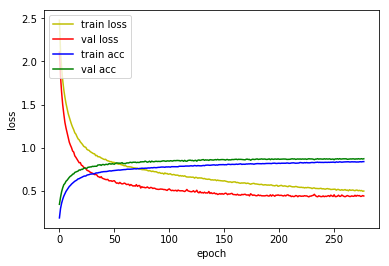

4815/4815 [==============================] - 3s 661us/sample - loss: 0.5234 - acc: 0.8390
Loss: 0.5234299747248181 Accuracy: 0.83904463

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3679 - acc: 0.2254
Epoch 00001: val_loss improved from inf to 1.89667, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_checkpoint/001-1.8967.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 2.3680 - acc: 0.2254 - val_loss: 1.8967 - val_acc: 0.4149
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8928 - acc: 0.3671
Epoch 00002: val_loss improved from 1.89667 to 1.54686, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_checkpoint/002-1.5469.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.8928 - acc: 0.3671 - val_loss: 1.5469 - val_acc: 0.5136
Epoch 3/500
36800/36805 [===========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6687 - acc: 0.7888
Epoch 00023: val_loss improved from 0.48139 to 0.44714, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_checkpoint/023-0.4471.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.6687 - acc: 0.7888 - val_loss: 0.4471 - val_acc: 0.8714
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6546 - acc: 0.7935
Epoch 00024: val_loss improved from 0.44714 to 0.43578, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_checkpoint/024-0.4358.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.6547 - acc: 0.7935 - val_loss: 0.4358 - val_acc: 0.8735
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6441 - acc: 0.7979
Epoch 00025: val_loss improved from 0.43578 to 0.42492, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_che

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4783 - acc: 0.8508
Epoch 00047: val_loss did not improve from 0.32173
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4783 - acc: 0.8508 - val_loss: 0.3239 - val_acc: 0.9001
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4791 - acc: 0.8474
Epoch 00048: val_loss did not improve from 0.32173
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4791 - acc: 0.8474 - val_loss: 0.3351 - val_acc: 0.8970
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4713 - acc: 0.8512
Epoch 00049: val_loss did not improve from 0.32173
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4713 - acc: 0.8512 - val_loss: 0.3267 - val_acc: 0.9003
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4685 - acc: 0.8534
Epoch 00050: val_loss did not improve from 0.32173
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.3884 - acc: 0.8776
Epoch 00073: val_loss improved from 0.28936 to 0.28761, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_checkpoint/073-0.2876.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3884 - acc: 0.8776 - val_loss: 0.2876 - val_acc: 0.9115
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3815 - acc: 0.8781
Epoch 00074: val_loss did not improve from 0.28761
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3814 - acc: 0.8781 - val_loss: 0.2877 - val_acc: 0.9119
Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3834 - acc: 0.8786
Epoch 00075: val_loss did not improve from 0.28761
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3834 - acc: 0.8786 - val_loss: 0.2968 - val_acc: 0.9094
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3158 - acc: 0.8973
Epoch 00101: val_loss did not improve from 0.26995
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3158 - acc: 0.8973 - val_loss: 0.2770 - val_acc: 0.9140
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3107 - acc: 0.9001
Epoch 00102: val_loss improved from 0.26995 to 0.26829, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_checkpoint/102-0.2683.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3107 - acc: 0.9000 - val_loss: 0.2683 - val_acc: 0.9194
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3204 - acc: 0.8964
Epoch 00103: val_loss improved from 0.26829 to 0.26663, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_4_conv_checkpoint/103-0.2666.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3204 - ac

Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2645 - acc: 0.9134
Epoch 00130: val_loss did not improve from 0.26548
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2644 - acc: 0.9134 - val_loss: 0.2776 - val_acc: 0.9161
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2679 - acc: 0.9130
Epoch 00131: val_loss did not improve from 0.26548
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2679 - acc: 0.9130 - val_loss: 0.2698 - val_acc: 0.9217
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2647 - acc: 0.9125
Epoch 00132: val_loss did not improve from 0.26548
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2647 - acc: 0.9125 - val_loss: 0.2803 - val_acc: 0.9145
Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2655 - acc: 0.9132
Epoch 00133: val_loss did not improve from 0.26548
36805/36805 [=======

Epoch 160/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2315 - acc: 0.9241
Epoch 00160: val_loss did not improve from 0.26548
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2316 - acc: 0.9241 - val_loss: 0.2759 - val_acc: 0.9175
Epoch 161/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2320 - acc: 0.9240
Epoch 00161: val_loss did not improve from 0.26548
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2320 - acc: 0.9240 - val_loss: 0.2837 - val_acc: 0.9164
Epoch 162/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2266 - acc: 0.9260
Epoch 00162: val_loss did not improve from 0.26548
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2266 - acc: 0.9260 - val_loss: 0.2883 - val_acc: 0.9180
Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2245 - acc: 0.9261
Epoch 00163: val_loss did not improve from 0.26548
36805/36805 [=======

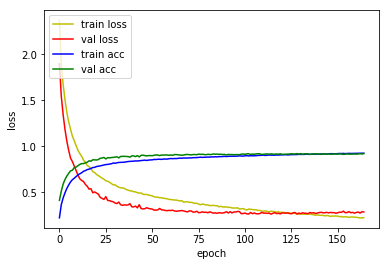

4815/4815 [==============================] - 3s 677us/sample - loss: 0.3335 - acc: 0.8989
Loss: 0.3334528922725194 Accuracy: 0.8988577

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1821 - acc: 0.2801
Epoch 00001: val_loss improved from inf to 1.52750, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_5_conv_checkpoint/001-1.5275.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 2.1820 - acc: 0.2801 - val_loss: 1.5275 - val_acc: 0.5430
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5209 - acc: 0.5050
Epoch 00002: val_loss improved from 1.52750 to 1.03462, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_5_conv_checkpoint/002-1.0346.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 1.5209 - acc: 0.5050 - val_loss: 1.0346 - val_acc: 0.6979
Epoch 3/500
36800/36805 [============================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2987 - acc: 0.9055
Epoch 00023: val_loss improved from 0.21212 to 0.21057, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_5_conv_checkpoint/023-0.2106.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2987 - acc: 0.9055 - val_loss: 0.2106 - val_acc: 0.9373
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2945 - acc: 0.9074
Epoch 00024: val_loss did not improve from 0.21057
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2945 - acc: 0.9074 - val_loss: 0.2110 - val_acc: 0.9387
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2931 - acc: 0.9088
Epoch 00025: val_loss did not improve from 0.21057
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2931 - acc: 0.9088 - val_loss: 0.2126 - val_acc: 0.9327
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1760 - acc: 0.9427
Epoch 00047: val_loss did not improve from 0.16474
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1759 - acc: 0.9427 - val_loss: 0.1713 - val_acc: 0.9481
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1723 - acc: 0.9441
Epoch 00048: val_loss did not improve from 0.16474
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1723 - acc: 0.9441 - val_loss: 0.1690 - val_acc: 0.9495
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1684 - acc: 0.9461
Epoch 00049: val_loss improved from 0.16474 to 0.16358, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_5_conv_checkpoint/049-0.1636.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1684 - acc: 0.9461 - val_loss: 0.1636 - val_acc: 0.9520
Epoch 50/500
36800/36805 [============================>.] - ETA:

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1087 - acc: 0.9648
Epoch 00076: val_loss did not improve from 0.16351
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1087 - acc: 0.9648 - val_loss: 0.1845 - val_acc: 0.9509
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0961 - acc: 0.9682
Epoch 00077: val_loss did not improve from 0.16351
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.0962 - acc: 0.9682 - val_loss: 0.1980 - val_acc: 0.9450
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9670
Epoch 00078: val_loss did not improve from 0.16351
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1015 - acc: 0.9670 - val_loss: 0.1740 - val_acc: 0.9504
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0940 - acc: 0.9691
Epoch 00079: val_loss did not improve from 0.16351
36805/36805 [===========

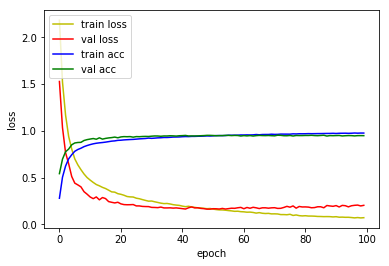

4815/4815 [==============================] - 3s 710us/sample - loss: 0.2227 - acc: 0.9298
Loss: 0.22265147672635371 Accuracy: 0.9298027

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9215 - acc: 0.3730
Epoch 00001: val_loss improved from inf to 1.02986, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_6_conv_checkpoint/001-1.0299.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 1.9214 - acc: 0.3731 - val_loss: 1.0299 - val_acc: 0.7102
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0451 - acc: 0.6673
Epoch 00002: val_loss improved from 1.02986 to 0.66868, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_6_conv_checkpoint/002-0.6687.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.0450 - acc: 0.6674 - val_loss: 0.6687 - val_acc: 0.8123
Epoch 3/500
36800/36805 [===========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1689 - acc: 0.9470
Epoch 00024: val_loss improved from 0.12883 to 0.12161, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_6_conv_checkpoint/024-0.1216.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1689 - acc: 0.9469 - val_loss: 0.1216 - val_acc: 0.9641
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1649 - acc: 0.9470
Epoch 00025: val_loss did not improve from 0.12161
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1649 - acc: 0.9470 - val_loss: 0.1304 - val_acc: 0.9634
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1573 - acc: 0.9515
Epoch 00026: val_loss did not improve from 0.12161
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.1573 - acc: 0.9516 - val_loss: 0.1398 - val_acc: 0.9574
Epoch 27/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0781 - acc: 0.9745
Epoch 00050: val_loss did not improve from 0.10579
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0781 - acc: 0.9745 - val_loss: 0.1248 - val_acc: 0.9618
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0694 - acc: 0.9762
Epoch 00051: val_loss did not improve from 0.10579
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0694 - acc: 0.9763 - val_loss: 0.1173 - val_acc: 0.9641
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9762
Epoch 00052: val_loss did not improve from 0.10579
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0711 - acc: 0.9762 - val_loss: 0.1185 - val_acc: 0.9658
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0679 - acc: 0.9773
Epoch 00053: val_loss did not improve from 0.10579
36805/36805 [========================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0360 - acc: 0.9876
Epoch 00080: val_loss did not improve from 0.10579
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0360 - acc: 0.9876 - val_loss: 0.1477 - val_acc: 0.9639
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0354 - acc: 0.9885
Epoch 00081: val_loss did not improve from 0.10579
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0354 - acc: 0.9885 - val_loss: 0.1599 - val_acc: 0.9620
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9887
Epoch 00082: val_loss did not improve from 0.10579
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0329 - acc: 0.9888 - val_loss: 0.1391 - val_acc: 0.9658
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9886
Epoch 00083: val_loss did not improve from 0.10579
36805/36805 [===========

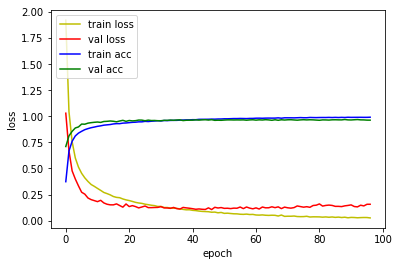

4815/4815 [==============================] - 4s 737us/sample - loss: 0.1419 - acc: 0.9545
Loss: 0.1418726274969979 Accuracy: 0.9545171

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6322 - acc: 0.4745
Epoch 00001: val_loss improved from inf to 0.69649, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_7_conv_checkpoint/001-0.6965.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.6321 - acc: 0.4746 - val_loss: 0.6965 - val_acc: 0.8048
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7278 - acc: 0.7728
Epoch 00002: val_loss improved from 0.69649 to 0.37831, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_7_conv_checkpoint/002-0.3783.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.7278 - acc: 0.7728 - val_loss: 0.3783 - val_acc: 0.8966
Epoch 3/500
36800/36805 [============================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1022 - acc: 0.9666
Epoch 00024: val_loss did not improve from 0.10375
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1022 - acc: 0.9666 - val_loss: 0.1117 - val_acc: 0.9655
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0966 - acc: 0.9680
Epoch 00025: val_loss improved from 0.10375 to 0.10051, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_7_conv_checkpoint/025-0.1005.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0966 - acc: 0.9680 - val_loss: 0.1005 - val_acc: 0.9713
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9699
Epoch 00026: val_loss did not improve from 0.10051
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0906 - acc: 0.9699 - val_loss: 0.1013 - val_acc: 0.9686
Epoch 27/500
36800/36805 [============================>.] - ETA:

36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9881
Epoch 00052: val_loss did not improve from 0.08741
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0342 - acc: 0.9881 - val_loss: 0.1038 - val_acc: 0.9741
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9896
Epoch 00053: val_loss did not improve from 0.08741
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0320 - acc: 0.9896 - val_loss: 0.1309 - val_acc: 0.9697
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9892
Epoch 00054: val_loss did not improve from 0.08741
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0327 - acc: 0.9892 - val_loss: 0.1094 - val_acc: 0.9720
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9905
Epoch 00055: val_loss did not improve from 0.08741
36805/36805 [========================

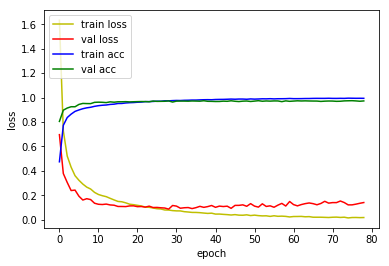

4815/4815 [==============================] - 3s 724us/sample - loss: 0.1401 - acc: 0.9556
Loss: 0.14011576245089186 Accuracy: 0.95555556

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4874 - acc: 0.5238
Epoch 00001: val_loss improved from inf to 0.63468, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_8_conv_checkpoint/001-0.6347.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 1.4873 - acc: 0.5238 - val_loss: 0.6347 - val_acc: 0.8134
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6311 - acc: 0.8005
Epoch 00002: val_loss improved from 0.63468 to 0.38305, saving model to model/checkpoint/1D_CNN_custom_multi_2_GMP_ch_128_DO_8_conv_checkpoint/002-0.3830.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.6311 - acc: 0.8005 - val_loss: 0.3830 - val_acc: 0.8810
Epoch 3/500
36800/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0580 - acc: 0.9812
Epoch 00026: val_loss did not improve from 0.10318
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0580 - acc: 0.9812 - val_loss: 0.1133 - val_acc: 0.9693
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9811
Epoch 00027: val_loss did not improve from 0.10318
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0575 - acc: 0.9811 - val_loss: 0.1129 - val_acc: 0.9686
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9822
Epoch 00028: val_loss did not improve from 0.10318
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0541 - acc: 0.9822 - val_loss: 0.1125 - val_acc: 0.9669
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9830
Epoch 00029: val_loss did not improve from 0.10318
36805/36805 [========================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9942
Epoch 00056: val_loss did not improve from 0.10318
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0188 - acc: 0.9942 - val_loss: 0.1488 - val_acc: 0.9679
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9955
Epoch 00057: val_loss did not improve from 0.10318
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0167 - acc: 0.9955 - val_loss: 0.1638 - val_acc: 0.9653
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0174 - acc: 0.9948
Epoch 00058: val_loss did not improve from 0.10318
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0174 - acc: 0.9948 - val_loss: 0.1884 - val_acc: 0.9620
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9933
Epoch 00059: val_loss did not improve from 0.10318
36805/36805 [===========

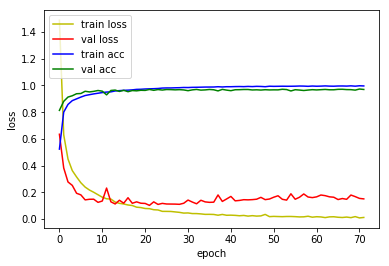

4815/4815 [==============================] - 4s 788us/sample - loss: 0.1606 - acc: 0.9522
Loss: 0.1606425730590849 Accuracy: 0.9522326



In [10]:
base = '1D_CNN_custom_multi_2_GMP_ch_128_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GMP_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
___________________________________________________________

4815/4815 [==============================] - 4s 779us/sample - loss: 0.2227 - acc: 0.9298
Loss: 0.22265147672635371 Accuracy: 0.9298027

1D_CNN_custom_multi_2_GMP_ch_128_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 128)   768         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 128)   0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxP

4815/4815 [==============================] - 4s 803us/sample - loss: 0.1401 - acc: 0.9556
Loss: 0.14011576245089186 Accuracy: 0.95555556

1D_CNN_custom_multi_2_GMP_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 128)   768         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 128)   0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (Max

In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GMP_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
___________________________________________________________

4815/4815 [==============================] - 4s 815us/sample - loss: 0.2569 - acc: 0.9346
Loss: 0.2568769861233197 Accuracy: 0.93457943

1D_CNN_custom_multi_2_GMP_ch_128_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 128)   768         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 128)   0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxP

4815/4815 [==============================] - 4s 871us/sample - loss: 0.2082 - acc: 0.9595
Loss: 0.20822969780146142 Accuracy: 0.95950156

1D_CNN_custom_multi_2_GMP_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 128)   768         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 128)   0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (Max